In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [183]:
df = pd.read_json('http://localhost:5000/analyzed/whole-json', dtype={'name': 'str'})
df['geometry'] = df.apply(lambda r: Point(r.lon, r.lat), axis=1)
df.drop(['lat', 'lon'], axis=1, inplace=True)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=4326)
gdf

,heading,height,histogram,name,pitch,width,geometry
0,6.303681e+01,884,"[266053, 82828, 774991, 8, 287, 364, 122, 1847...",20231023_003941,1.214360,1442,POINT (139.69607 35.68761)
1,7.848084e+01,884,"[19183, 13605, 980578, 0, 122200, 1777, 462, 1...",20231027_130350,-24.246709,1442,POINT (139.69058 35.68787)
2,8.278976e+01,884,"[130153, 9510, 739569, 38112, 4439, 3065, 1, 4...",20231026_225924,-2.207011,1442,POINT (139.68945 35.68837)
3,3.578980e+02,884,"[5130, 0, 1176535, 3356, 46367, 2826, 0, 770, ...",20231025_231700,-73.050990,1442,POINT (139.70052 35.68687)
4,6.048588e+01,884,"[88477, 22388, 849512, 0, 5871, 286, 0, 357, 2...",20231022_234940,-3.692718,1442,POINT (139.69552 35.68725)
5,5.767713e+01,884,"[45952, 2, 912110, 1147, 137930, 516, 907, 224...",20231027_130439,-15.244258,1442,POINT (139.69692 35.68770)
6,6.237132e+01,884,"[404344, 90353, 681379, 501, 2989, 5952, 4, 78...",20231022_235028,-1.698060,1442,POINT (139.69571 35.68744)
7,3.478202e+02,884,"[29485, 352, 1123379, 4351, 62769, 1776, 0, 33...",20231025_221658,-53.239194,1442,POINT (139.70179 35.68423)
8,2.454981e-09,884,"[30491, 1354, 1121939, 4692, 24129, 1035, 24, ...",20231022_231323,-44.397441,1442,POINT (139.70040 35.68306)
9,6.048593e+01,884,"[196309, 11346, 878361, 0, 7822, 0, 0, 218, 2,...",20231022_234950,-3.692636,1442,POINT (139.69561 35.68729)


In [184]:
import folium
import branca

map = folium.Map(location=[35, 139], zoom_start=7)
fg = folium.FeatureGroup(name="Pika")
for n, row in df[[u'geometry', u'name', u'height']].iterrows():
    p, n, h = row[u'geometry'], row[u'name'], row[u'height']
    html = f'{n}<img src="http://localhost:5000/analyzed/image/{n}.png" width="400" />'
    iframe = branca.element.IFrame(html=html, width=400, height=350)
    marker = folium.Marker(location=(p.y, p.x), popup=folium.Popup(iframe, max_width=400))
    fg.add_child(marker)
map.add_child(fg)
map

In [185]:
from IPython.display import display, HTML
from ipywidgets import IntRangeSlider, interactive

pitcher = IntRangeSlider(value=[-90, 0], min=-90, max=10, step=1)
adf = gdf

def on_value_change(pitch_range):
    p_min, p_max = pitch_range
    global adf
    adf = gdf[(p_min<=gdf.pitch)&(gdf.pitch<p_max)]
    urls = adf.name.apply(lambda n: f'http://localhost:5000/analyzed/image/{n}.png').to_list()
    imgs = [f"<img style='width: 300px; margin: 0px; float: left; border: 1px solid black;' src='{url}' />" for url in urls]
    display(HTML(''.join(imgs)))

interactive(on_value_change, pitch_range=pitcher)


interactive(children=(IntRangeSlider(value=(-90, 0), description='pitch_range', max=10, min=-90), Output()), _…

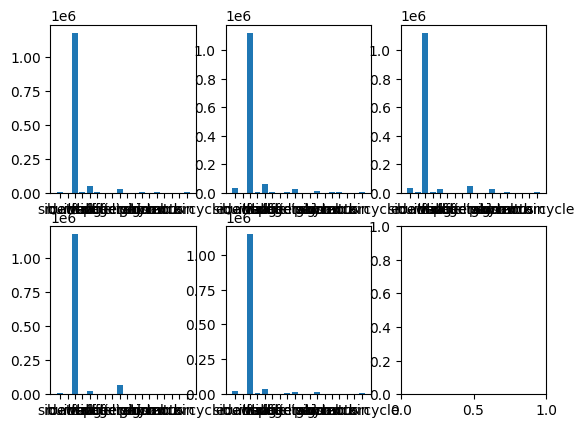

In [186]:
import json
import matplotlib.pyplot as plt

classes = json.load(open('cityscapes_labels.json'))['classes'][:-1]
cols = 3
bdf = adf.reset_index(drop=True)
fig, axes = plt.subplots(len(bdf)//cols+1, cols)
for i in bdf.index:
    axes[i//cols, i%cols].bar(classes, bdf.iloc[i].histogram)